In [3]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import csv
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
import sys
import random
import pandas as pd
from rerank_score_cands_new import load_cands
import numpy as np
from comet import download_model, load_from_checkpoint
import pickle
from sklearn.utils import shuffle
#from distill_comet import XLMCometRegressor

csv.field_size_limit(sys.maxsize)
xlm_tok = AutoTokenizer.from_pretrained('xlm-roberta-base')


In [4]:
class XLMCometRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.1):
        # TODO should we be freezing layers?
        super().__init__()
        
        self.xlmroberta = AutoModel.from_pretrained('xlm-roberta-base')
        # Num labels 1 should just indicate regression (?)
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(self.xlmroberta.config.hidden_size, 1), 
        )
        self.to(device)
        
    def forward(self, input_ids, attention_masks):
        # don't finetune xlmroberta model
        #with torch.no_grad():
        word_rep, sentence_rep = self.xlmroberta(input_ids, attention_mask=attention_masks, encoder_attention_mask=attention_masks, return_dict=False)
        # use the first <s> token as a CLS token, TODO experiment with using the sum of 
        # ensure padding not factored in
        word_rep = word_rep*(input_ids>0).unsqueeze(-1)
        outputs = self.regressor(torch.sum(word_rep, 1))
        #print("Shape: ", outputs.shape)
        return outputs

In [ ]:
# nothing is everything
# 1 is with distilled data lattice + beam
# 2 is with just beam data? 
# ordered is the clean ranking ready set
def load_cometqe_data(ind):
    with open('processeddata/orderedmasks.pkl', 'rb') as f:
        masks = pickle.load(f)

    with open('processeddata/orderedinps.pkl', 'rb') as f:
        xinps = pickle.load(f)

    with open('processeddata/orderedlabels.pkl', 'rb') as f:
        yinps = pickle.load(f)
    return masks, xinps, yinps

mdata, xdata, ydata = load_cometqe_data(1)

In [3]:
# train test split
cut = int(len(xdata)*.9)- int(len(xdata)*.9)%32
xtrain, ytrain, mtrain = xdata[:cut], ydata[:cut], mdata[:cut]
xtest, ytest, mtest = xdata[cut:], ydata[cut:], mdata[cut:]

NameError: name 'xdata' is not defined

In [4]:
del mdata, xdata, ydata
torch.cuda.empty_cache()

NameError: name 'mdata' is not defined

In [ ]:
testset = torch.tensor(ytrain[:31]+[.8]).to(device)

In [24]:
len(xtrain)

145728

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class RegressionDataset(Dataset):
    def __init__(self, sentences, labels, masks):
        assert len(sentences) == len(labels)
        self.sentences = sentences
        self.labels = labels
        self.masks = masks

    def __getitem__(self, i):
        return self.sentences[i], self.labels[i], self.masks[i]

    def __len__(self):
        return len(self.sentences)

def collate_custom(datafull):
    #print(len(datafull[0]))
    data = [torch.tensor(d[0]) for d in datafull]
    masdata=  [d[2] for d in datafull]
    labels = [d[1] for d in datafull]
    max_len = max([x.squeeze().numel() for x in data])
    data = [torch.nn.functional.pad(x, pad=(0, max_len - x.numel()), mode='constant', value=0) for x in data]
    data = torch.stack(data).to(device)
    # TODO just a normal mask for now
    #masdata = [torch.ones_like(m) for m in masdata]
    masdata = [torch.nn.functional.pad(x, pad=(0, max_len - x[0].numel(), 0, max_len - x[0].numel()), mode='constant', value=0) for x in masdata]
    masdata = torch.stack(masdata).to(device)
    return data, torch.tensor(labels).to(device), masdata
    

In [6]:
testloader = DataLoader(RegressionDataset(xtest, ytest, mtest), batch_size=32, shuffle=False, collate_fn=collate_custom)
trainloader = DataLoader(RegressionDataset(xtrain, ytrain, mtrain), batch_size=32, shuffle=False, collate_fn=collate_custom)

NameError: name 'xtest' is not defined

In [ ]:
tinmax = 100000
xtiny, ytiny, mtiny = xtrain[:tinmax], ytrain[:tinmax], mtrain[:tinmax]
tinyloader = DataLoader(RegressionDataset(xtiny, ytiny, mtiny), batch_size=32, shuffle=True, collate_fn=collate_custom)

In [ ]:
it = iter(testloader)

In [8]:
# hyperparams
from transformers import AdamW, get_linear_schedule_with_warmup

In [9]:
from torch.nn.utils.clip_grad import clip_grad_norm_
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    print("Total steps :", epochs*len(train_dataloader))
    best_loss = 1e10
    for epoch in range(epochs):
        if epoch%1==0:
            print("EPOCH ", epoch)
            print("-----")
            print(best_loss)
        model.train()
        cbest = 1e10
        lostot = 0
        loscnt = 0
        for step, batch in enumerate(train_dataloader): 
            batch_inputs, batch_labels, batch_masks = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
            lostot+=loss
            loscnt+=1
            if step%500==0:
                #print(loss)  
                if loscnt>0:
                    print(lostot/loscnt)
                    cbest = min(float(lostot/loscnt), cbest)
                    best_loss = min(best_loss, cbest)
                    print("cbest, ", cbest)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
        cbest = min(float(lostot/loscnt), cbest)
        best_loss = min(best_loss, cbest)
        print("cbest, ", cbest)
        
        torch.save(model.state_dict(), "torchsaved/divlat"+str(epoch)+".pt")
    return model

def evaluate(model, loss_function, tdataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    preds = []
    ind = 0
    for batch in tdataloader:
        if ind%100==0:
            print(ind)
        try:
            batch_inputs, batch_labels,batch_masks = \
                                     tuple(b.to(device) for b in batch)
            with torch.no_grad():
                outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.squeeze(), 
                                 batch_labels.squeeze())
            preds.append(list(outputs.squeeze()))
            test_loss.append(loss.item())
            #r2 = r2_score(outputs, batch_labels)
            #test_r2.append(r2.item())
            if ind==10:
                print(batch_labels)
                print(outputs)
            ind+=1
        except:
            preds.append([0.5]*32)
            test_loss.append(0)
            
    return test_loss, preds

In [41]:
#torch.save(model.state_dict(), "torchsaved/maskedtestcomestimdone.pt")

In [10]:
model = XLMCometRegressor(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/germanlat0.pt"))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
model.eval()

In [12]:
# maskedcont1 has first round of optimizing loss
# maskedcont2 more contrastive learning
# maskedcont3 full on contrastive 
# torch.save(model.state_dict(), "torchsaved/maskedcont4.pt")

In [13]:
torch.cuda.empty_cache()

In [14]:
vmask = (torch.triu(torch.ones(32, 32))*2-torch.ones(32, 32))*-1
vmask = vmask.to(device)
mse = nn.MSELoss()
def rank_loss(preds, golds):
    totloss = 0
    for i in range(1, len(preds)):
        # for margin
        margin = (golds - torch.roll(golds, i))*vmask[i]
        diff = (preds - torch.roll(preds, i)-margin)*vmask[i]
        diff[diff<0] = 0
        totloss+=torch.sum(diff)
    return totloss + mse(preds, golds)

In [15]:
vmask = (torch.triu(torch.ones(32, 32))*2-torch.ones(32, 32))*-1
vmask = vmask.to(device)
mse = nn.MSELoss()
def nomarg_rank_loss(preds, golds):
    totloss = 0
    for i in range(1, len(preds)):
        # for margin
        # margin = (golds - torch.roll(golds, i))*vmask[i]
        diff = (preds - torch.roll(preds, i))*vmask[i]
        diff[diff<0] = 0
        totloss+=torch.sum(diff)
    return totloss + mse(preds, golds)

In [16]:
def run_model_train_params(learn_r, epochs, loader, mod):
    optimizer = AdamW(mod.parameters(),
                      lr=learn_r,
                      eps=1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer,       
                     num_warmup_steps=0, num_training_steps=epochs*len(loader))
    model = train(mod, optimizer, scheduler, rank_loss, epochs, 
                  loader, device, clip_value=2)

In [53]:
#run_model_train_params(1e-4, 2, bigloader, model)
run_model_train_params(1e-5, 10, bigloader, model)
run_model_train_params(1e-6, 20, bigloader, model)


Total steps : 16516
EPOCH  0
-----
10000000000.0
tensor(26.8449, device='cuda:1', grad_fn=<DivBackward0>)
cbest,  26.84491729736328
tensor(62.9235, device='cuda:1', grad_fn=<DivBackward0>)
cbest,  26.84491729736328


RuntimeError: The expanded size of the tensor (553) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [32, 553].  Tensor sizes: [1, 514]

In [50]:
ittest = iter(bigloader)

In [ ]:
for t in trainloader:
    #print(t[1])
    assert t[1][-1] == max(t[1])

In [77]:
del model 
model = XLMCometRegressor(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/maskedcont4.pt"))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [42]:
loss = evaluate(model, rank_loss, testloader, device)

100
200
300
400
500


In [12]:
import math
import matplotlib.pyplot as plt

In [ ]:
len(xtrain)

In [ ]:
sloss = [math.sqrt(l) for l in loss[0]]

In [ ]:
nval = [float(l) for l in loss[1]]

In [ ]:
mind = []
for l in loss[1]:
    mind+=[l.index(max(l))]

sum(mind)/len(mind)

In [2]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(alldf['scores'])

In [80]:
# old data loading stuff

# data comes from WMT 2019 [I think], TODO validate exact year being used
# data generated with gold reference given as hyp
#golddf = pd.read_csv('./processeddata/golddata.csv')
#golddf['inp'] = golddf['fr']
#golddf['hyp'] = golddf['en']
# data generated on candidates from beam search 50 and lattice (lots of bad)
distill_df = pd.read_csv('processeddata/cpfdata2.csv')
# data generated between random / unrelated sentences 
#rand_df = pd.read_csv('distill_cometdata_rand.csv')[:30000]
# combine
alldf = distill_df#.append(rand_df, ignore_index=True)

In [81]:
alldf

,Unnamed: 0,src,hyp,ref,score,comscores,posthoc
0,0,"Après tout, en tant que journaliste d'investig...","After all, as an investigative reporter in the...","After all, as a campaigning investigative jour...",0.423756,0.001024,0.534086
1,1,"Après tout, en tant que journaliste d'investig...","After all, as a field investigative journalist...","After all, as a campaigning investigative jour...",0.500724,0.187095,0.493034
2,2,"Après tout, en tant que journaliste d'investig...","After all, as an investigative reporter in the...","After all, as a campaigning investigative jour...",0.377539,0.009930,0.544490
3,3,"Après tout, en tant que journaliste d'investig...","After all, as a journalist investigating the c...","After all, as a campaigning investigative jour...",0.240281,0.006175,0.509931
4,4,"Après tout, en tant que journaliste d'investig...","After all, as a journalist investigating in th...","After all, as a campaigning investigative jour...",0.253478,0.000042,0.760619
...,...,...,...,...,...,...,...
309135,309135,De grosses erreurs ont été commises qui ont en...,Large errors were committed which further fuel...,"Big mistakes were made, fueling further violen...",0.798258,0.331076,0.684784
309136,309136,De grosses erreurs ont été commises qui ont en...,Major mistakes were made and the violence was ...,"Big mistakes were made, fueling further violen...",0.803969,0.414651,0.797772
309137,309137,De grosses erreurs ont été commises qui ont en...,Big mistakes have been made and the violence c...,"Big mistakes were made, fueling further violen...",0.747567,0.365663,0.942066
309138,309138,De grosses erreurs ont été commises qui ont en...,Big mistakes have been made and they have furt...,"Big mistakes were made, fueling further violen...",0.864925,0.487513,0.732962


In [82]:
sorted3 = alldf.sort_values(['ref', 'score']).reset_index().drop(columns=['index', 'Unnamed: 0'])
sorted3 = sorted3[sorted3["src"].str.contains("&#")==False]
sorted3 = sorted3[sorted3['src'].str.len()>40]
sorted3 = sorted3[sorted3['ref'].str.len()>40]

In [83]:
#sorted3.to_csv("processeddata/cpfdata0")
stind = 9
sorted3[:4]

,src,hyp,ref,score,comscores,posthoc
0,« La médecine clinique est-elle corrompue ? » ...,"""Is clinical medicine corrupt?"" asked an edito...","""Just how tainted has clinical medicine become...",0.104513,0.290672,0.564603
1,« La médecine clinique est-elle corrompue ? » ...,"""Is clinical medicine corrupt?"" asked an edito...","""Just how tainted has clinical medicine become...",0.152255,0.299467,0.566226
2,« La médecine clinique est-elle corrompue ? » ...,"""Is clinical medicine corrupt?"" an editorial i...","""Just how tainted has clinical medicine become...",0.178602,0.273248,0.531792
3,« La médecine clinique est-elle corrompue ? » ...,"""Is clinical medicine corrupt?"" asked an edito...","""Just how tainted has clinical medicine become...",0.183225,0.298458,0.597017


In [84]:
sorted3['weighted'] = (-1.25)*sorted3['posthoc']+(0.9)*sorted3['comscores']

In [85]:
# go through dataframe, get sets of size BATCH that are ranked by score
dlists = []
prevs = sorted3['src'].iloc[0]
sofar = []
for index, row in sorted3.iterrows():
    if row['src']==prevs:
        sofar.append(row)
    else:
        dlists.append(sofar)
        sofar = []
        prevs = row['src']

In [86]:
len(dlists)

4587

In [87]:
# get the last 90% as set to work with
dls = dlists[:int(len(dlists)/10)]

In [88]:
allvals = []
for d in dls:
    allvals.extend(d)

In [89]:
import random

In [ ]:
batch = 32
# sample from stuff, 32 at a time
def get_samples(dlist, best, batch):
    nbatches = int(len(dlist)/batch)+1
    res = []
    for i in range(nbatches):
        print(len(dlist))
        # get a random sorted sample, make sure best is in each batch
        indices = random.sample(range(len(dlist)), batch-1)
        res.append([dlist[i] for i in sorted(indices)]+[best])
    return res

def all_samples(dls, batch):
    done = []
    for d in dls:
        done.extend(get_samples(d[:-1], d[-1], batch))
    return done

asamps = all_samples(dls, 32)

In [91]:
random.shuffle(asamps)

In [92]:
done = []
for a in asamps:
    done.extend(a)

In [93]:
done = pd.DataFrame(done)

In [94]:
done = done.reset_index().drop(columns= ['index'])

In [36]:
done.loc[31+32]

src          But that seems unlikely: since the Democrats’ ...
hyp          Aber das scheint unwahrscheinlich: Seit der gr...
ref          Aber das scheint unwahrscheinlich: Seit der gr...
score                                                 0.835206
comscores                                             0.560319
posthoc                                                5.20967
weighted                                               -6.0078
Name: 63, dtype: object

In [95]:
MAXTOKS =512
# construct inputs from dataframe
def get_inputs(inpdf):
    xinp = []
    yinp = []
    maskinp = []
    
    for index, row in inpdf.iterrows():
        if index%1000==0:
            print(index)
        #print(row['c1'], row['c2'])
        # will need to make a custom mask (maybe) so that inputs from both languages are encoded separately
        toktmp = xlm_tok(row['src']).input_ids
        lent = len(toktmp)
        hyptmp = xlm_tok(row['hyp']).input_ids
        toktmp.extend(hyptmp)
        tlen = min(len(toktmp), MAXTOKS)
        toktmp = toktmp[:tlen]
        mask = torch.ones(tlen, tlen)
        # should set upper left and bottom right quadrants to 1, mask other stuff
        # TODO make different types of masks. 
        # make causal encoder-decoder mask
        mask[:lent, lent:] = 0
        mask[lent:, lent:] = torch.tril(mask[lent:, lent:])
        xinp.append(toktmp)
        maskinp.append(mask)
        yinp.append(row['score'])
    return xinp, yinp, maskinp

In [96]:
xdata, ydata, mdata = get_inputs(done)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


Token indices sequence length is longer than the specified maximum sequence length for this model (789 > 512). Running this sequence through the model will result in indexing errors


11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [39]:
bigloader = DataLoader(RegressionDataset(xdata, ydata, mdata), batch_size=32, shuffle=False, collate_fn=collate_custom)

In [39]:
iterbig = iter(bigloader)

In [40]:
inext = iterbig.next()

In [41]:
xlm_tok.decode(inext[0][0])

'<s> Après tout, les taux d’intérêt en Europe du Sud dépassaient largement les 10 % au cours de la décennie précédant l’introduction de l’euro.</s><s> After all, interest rates in southern Europe far exceeded 10% in the decade leading up to the euro.</s><s><s><s><s><s>'

In [65]:
srcs = list(set(done['src']))

In [66]:
len(srcs)

1042

In [69]:
import flatten_lattice as fl
import os

In [102]:
len(os.listdir(fren))

3027

In [97]:
done.to_csv("french_test.csv")

In [101]:
ende = "custom_output/data/mt1n_en-de_bfs_recom_4_80_False_0.4_True_False_4_5_rcb_0.904_0.0_0.9/"
fren = "custom_output/data/mtn1_fr-en_bfs_recom_4_-1_False_0.4_True_False_4_5_rcb_0.903_0.0_0.9/"
def lattice_test_names(folder, srcnames):
    for name in os.listdir(folder):
        g = pickle.load(open(folder+name))
        

In [71]:
l = os.listdir("custom_output/data/mt1n_en-de_bfs_recom_4_80_False_0.4_True_False_4_5_rcb_0.904_0.0_0.9")
len(l)

11577

In [76]:
ende+os.listdir(ende)[0]

'custom_output/data/mt1n_en-de_bfs_recom_4_80_False_0.4_True_False_4_5_rcb_0.904_0.0_0.9/mt1n_en-de_bfs_recom_4_80_False_0.4_True_False_4_5_rcb_0.904_0.0_0.9_305_But-it-is-.pkl'

In [78]:
g = pickle.load(open(ende+os.listdir(ende)[0], 'rb'))

usage: ipykernel_launcher.py [-h] [-exploded EXPLODED] [-device DEVICE]
                             [-model {dbs,bs,greedy,topp,temp,bs_recom,sample_recom,bfs,bfs_recom}]
                             [-beam_size BEAM_SIZE] [-nexample NEXAMPLE]
                             [-task {sum,mt1n,mtn1,custom}] [-dataset DATASET]
                             [-hf_model_name HF_MODEL_NAME]
                             [-path_output PATH_OUTPUT] [-top_p TOP_P]
                             [-temp TEMP] [-beam_group BEAM_GROUP]
                             [-hamming_penalty HAMMING_PENALTY]
                             [-extra_steps EXTRA_STEPS] [-min_len MIN_LEN]
                             [-max_len MAX_LEN]
                             [-num_beam_hyps_to_keep NUM_BEAM_HYPS_TO_KEEP]
                             [-ngram_suffix NGRAM_SUFFIX] [-len_diff LEN_DIFF]
                             [-k_best K_BEST] [-avg_score AVG_SCORE]
                             [-use_heu [USE_HEU]] [-post [POST]]
  

SystemExit: 2

In [77]:
g

NameError: name 'g' is not defined

In [40]:
loss = evaluate(model, nomarg_rank_loss, bigloader, device)

100
200
300
400
500
600
700
800
900
1000


In [ ]:
loss[1]

In [41]:
import pickle

In [27]:
with open("testpreds.pkl", "wb") as f:
    pickle.dump(loss, f)

In [42]:
allpreds = []
for l in loss[1]:
    allpreds.extend(l)

In [43]:
avals = [a['score'] for a in allvals]

In [45]:
lens = [len(d) for d in asamps]

In [38]:
avsplit = []
apsplit = []
cur = 0
for l in lens:
    avsplit.append(avals[cur:cur+l])
    apsplit.append(allpreds[cur:cur+l])
    cur = cur+l

In [46]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
tmpsamps = [a[:-1] for a in asamps]

In [48]:
len(tmpsamps[3])

31

In [ ]:
# get stuff using our lattice encoding pipeline


In [62]:
def max_by_metric(metr, samps, ifmax):
    mlist = [float(f[metr]) for f in samps]
    if ifmax:
        index_max = np.argmax(mlist) 
    else:
        index_max = np.argmin(mlist) 
    return samps[int(index_max)]['score']

def update_values(sampstuff):
    tot = 0
    mval = 0 
    cnt = 0
    pred_dist = []
    gold_dist = []
    com_dist = []
    ph_dist = []
    weight_dist = []
    ourweight_dist = []
    for i in range(0, len(sampstuff)):
        index_max = np.argmax([float(f) for f in loss[1][i][:len(sampstuff[i])]])
        pred_dist.append(sampstuff[i][int(index_max)]['score'])
        tmpw = [float(loss[1][i][j])*0.9+sampstuff[i][j]['posthoc']*(-.5) for j in range(len(sampstuff[i]))]
        index_max = np.argmax(tmpw)
        ourweight_dist.append(sampstuff[i][int(index_max)]['score'])
        tot+=pred_dist[-1]
        m = -5
        for val in sampstuff[i]:
            m = max(m, val['score'])
        com_dist.append(max_by_metric('comscores', sampstuff[i], True))
        ph_dist.append(max_by_metric('posthoc', sampstuff[i], False))
        weight_dist.append(max_by_metric('weighted', sampstuff[i], True))
        gold_dist.append(m)
        mval+=m
        cnt+=1
    print("Our model ", tot/cnt)
    print("Gold ", mval/cnt)
    print("Just COMET", sum(weight_dist)/len(weight_dist))
    print("Just post-hoc", sum(ph_dist)/len(ph_dist))
    print("Weighted COMET+post-hoc", sum(com_dist)/len(com_dist))
    print("Our weighted ", sum(ourweight_dist)/len(ourweight_dist))
    

In [103]:
update_values(tmpsamps)

Our model  0.3314042544963317
Gold  0.6495842319274538
Just COMET 0.47004136759891085
Just post-hoc 0.40897692126340734
Weighted COMET+post-hoc 0.5748562992975639
Our weighted  0.40923807891120173


In [109]:
res = []
for lo in loss[1]:
    for l in lo:
        res.append(float(l))

(array([6.0840e+03, 1.3725e+04, 9.4040e+03, 3.7160e+03, 1.3470e+03,
        2.5100e+02, 6.4000e+01, 1.5000e+01, 1.5000e+01, 3.0000e+00]),
 array([0.44550452, 0.44874629, 0.45198807, 0.45522984, 0.45847161,
        0.46171339, 0.46495516, 0.46819694, 0.47143871, 0.47468049,
        0.47792226]),
 <BarContainer object of 10 artists>)

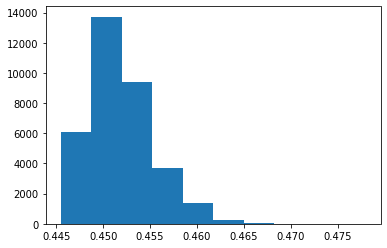

In [110]:
plt.hist(res)

In [117]:
for alist in tmpsamps:
    for a in alist:
        a['weighted'] = (-1.25)*a['posthoc']+(1)*a['comscores']

In [102]:
#sorted3['weighted'] = (-1.25)*sorted3['posthoc']+(.9)*sorted3['comscores']

In [57]:
sum(weight_dist)/len(weight_dist)

0.6869075171600706

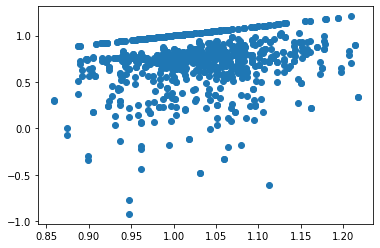

In [94]:
plt.scatter(gold_dist, pred_dist)

(array([  2.,   1.,   7.,   9.,  15.,  55.,  60., 332., 305., 131.]),
 array([-0.92208248, -0.70902837, -0.49597425, -0.28292014, -0.06986603,
         0.14318809,  0.3562422 ,  0.56929632,  0.78235043,  0.99540455,
         1.20845866]),
 <BarContainer object of 10 artists>)

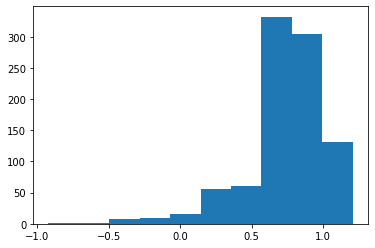

In [95]:
plt.hist(pred_dist)

(array([ 14.,  42., 110., 163., 180., 190., 116.,  54.,  36.,  12.]),
 array([0.85879219, 0.89463915, 0.93048611, 0.96633307, 1.00218003,
        1.03802699, 1.07387395, 1.10972091, 1.14556787, 1.18141483,
        1.21726179]),
 <BarContainer object of 10 artists>)

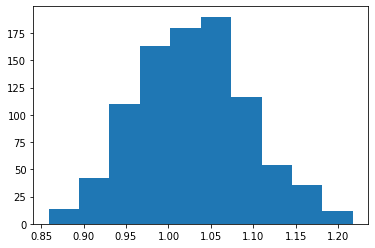

In [96]:
plt.hist(gold_dist)

In [42]:
def get_top_avgs():
    avdistr = []
    apdistr = []
    for i in range(len(avsplit)):
        try:
            vtmp = torch.tensor(avsplit[i])
            ptmp = torch.tensor(apsplit[i])
            if vtmp[-1]<0.5:
                continue
            #print(ptmp)
            apdistr.append(vtmp[int(torch.argmax(torch.tensor(ptmp)))])
            avdistr.append(vtmp[int(torch.argmax(torch.tensor(vtmp)))])
        except:
            print("something wrong")
            print(i)
    return avdistr, apdistr

av_distr, ap_distr = get_top_avgs()

/tmp/ipykernel_2281265/1805698635.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  apdistr.append(vtmp[int(torch.argmax(torch.tensor(ptmp)))])
/tmp/ipykernel_2281265/1805698635.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avdistr.append(vtmp[int(torch.argmax(torch.tensor(vtmp)))])


In [46]:
sum(ap_distr)/len(ap_distr)

tensor(0.8024)

In [47]:
sum(av_distr)/len(ap_distr)

tensor(0.8291)

In [40]:
import matplotlib.pyplot as plt

(array([ 2.,  4.,  6., 13., 15.,  3.,  5.,  1.,  0.,  1.]),
 array([0.49793291, 0.57491657, 0.65190022, 0.72888387, 0.80586753,
        0.88285118, 0.95983484, 1.03681849, 1.11380215, 1.1907858 ,
        1.26776946]),
 <BarContainer object of 10 artists>)

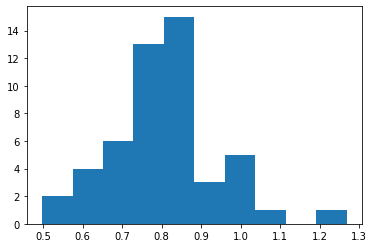

In [43]:
plt.hist([float(f) for f in ap_distr])

In [120]:
sum(av_distr) / len(ap_distr)

tensor(0.9036)

(array([2., 4., 0., 4., 1., 1., 0., 1., 1., 1.]),
 array([0.73842299, 0.78217971, 0.82593644, 0.86969316, 0.91344988,
        0.95720661, 1.00096333, 1.04472005, 1.08847678, 1.1322335 ,
        1.17599022]),
 <BarContainer object of 10 artists>)

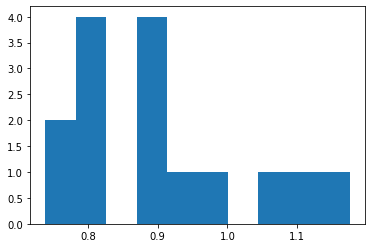

In [104]:
plt.hist([float(f) for f in av_distr])

In [33]:
for i in range(0, len(xdata)):
    if len(xdata[i])>500:
        del xdata[i]
        del ydata[i]
        del mdata[i]

In [40]:
# save all as precaution
def save_cometqe_data(md, xd, yd):
    # save data into a pickle file
    with open('processeddata/germanlatmasks.pkl', 'wb') as f:
        pickle.dump(md, f)

    with open('processeddata/germanlatinps.pkl', 'wb') as f:
        pickle.dump(xd, f)

    with open('processeddata/germanlatlabels.pkl', 'wb') as f:
        pickle.dump(yd, f)
        
#mdata, xdata, ydata = load_cometqe_data()
        
save_cometqe_data(mdata, xdata, ydata)

In [79]:
import json
fren = './rerank_outputs/post1explodedmtn1_fr-en_bfs_recom_4_-1_False_0.4_True_False_4_5_rcb_0.9_0.0_0.9.json'
ende = './rerank_outputs/post1explodedmt1n_en-de_bfs_recom_4_80_False_0.4_True_False_4_5_rcb_0.9_0.0_0.9.json'
# Opening JSON file
with open(fren) as json_file:
    lat4 = json.load(json_file)['data']
    
# was post1cpybeam4fr_en
with open('./rerank_outputs/post2post1beam49fr_en.json') as json_file:
    beam49 = json.load(json_file)['data']
    
def json_to_df(inputs):
    res = []
    for inp in inputs:
        tlist = []
        for i in range(len(inp['cands'])):
            tmp = {}
            tmp['src'] = inp['src']
            tmp['ref'] = inp['ref']
            tmp['hyp'] = inp['cands'][i]
            tmp['scores'] = inp['cometscores'][i]
            tlist.append(tmp)
        res.append(tlist)
    return res

dlists = json_to_df(lat4)